In [1]:
# 自动计算cell的计算时间
%load_ext autotime

#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[2] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 5.19 s (started: 2021-07-25 18:19:14 +08:00)


In [2]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 14.1 ms (started: 2021-07-25 18:19:19 +08:00)


# 机器学习基础

本章包含以下内容：
* 理解泛化和优化之间的张力，这是机器学习的基本问题
* 机器学习模型的评估方法
* 改进模型拟合的最佳实践
* 实现更好泛化的最佳实践

在第 4 章中的三个实际示例之后，您应该开始熟悉如何使用神经网络处理分类和回归问题，并且您已经目睹了机器学习的核心问题：过度拟合。 本章将把你对机器学习的一些新直觉形式化为一个坚实的概念框架，强调准确模型评估的重要性以及训练和泛化之间的平衡。

## 泛化：机器学习的目标

在第 4 章介绍的三个示例中——预测电影评论、主题分类和房价回归——我们将数据分成训练集、验证集和测试集。 不使用它们训练的相同数据评估模型的原因很快就变得明显了：仅仅几个 epoch 之后，前所未见的数据上的性能就开始与训练数据上的性能有所不同——随着训练的进行，这种性能总是有所提高。 模型开始过度拟合。 过拟合发生在每个机器学习问题中。

机器学习的基本问题是优化和泛化之间的张力。 优化是指调整模型以在训练数据上获得最佳性能的过程（学习机器学习），而泛化是指经过训练的模型在它以前从未见过的数据上的表现。 游戏的目标当然是获得良好的泛化，但你无法控制泛化； 您只能将模型拟合到其训练数据中。 如果你这样做，过度拟合就会开始，泛化就会受到影响。

但是是什么导致过拟合呢？ 如何实现良好的泛化？

### 欠拟合和过拟合

对于您在前一章中看到的所有模型，保留验证数据的性能开始随着训练的进行而提高，然后不可避免地在一段时间后达到顶峰。 这种模式（如图 5.1 所示）是通用的。 您将在任何模型类型和任何数据集上看到它。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gst75sd84mj31ey0qgmyu.jpg)

在训练开始时，优化和泛化是相关的：训练数据的损失越低，测试数据的损失就越低。 在发生这种情况时，您的模型被认为是欠拟合的：仍有待取得进展； 该网络尚未对训练数据中的所有相关模式进行建模。 但是在对训练数据进行一定次数的迭代后，泛化停止提高，验证指标停滞，然后开始降级：模型开始过度拟合。 也就是说，它开始学习特定于训练数据但在涉及新数据时具有误导性或无关性的模式。

当您的数据嘈杂、涉及不确定性或包含稀有特征时，特别有可能发生过度拟合。 我们来看具体的例子。

**嘈杂的训练数据**

在现实世界的数据集中，某些输入无效是很常见的。 例如，MNIST 数字可能是全黑图像。 或者像这样：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstcwq1qyuj30vs0n2n05.jpg)

这些是什么？ 我也不知道。 但它们都是 MNIST 训练集的一部分。 然而，更糟糕的是，完全有效的输入最终被错误标记。 像这些：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstcxooaxoj31ay0dg76d.jpg)

如果模型不顾一切地合并这些异常值，它的泛化性能就会下降，如图 5.4 所示。 例如，看起来非常接近上面错误标记的 5 的 5 可能最终被归类为 7。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstcyrdcjlj31b80lkacc.jpg)

**模棱两可的特征**

并非所有数据噪声都来自不准确——即使是完全干净且标记整齐的数据，当问题涉及不确定性和歧义时，也可能存在噪声。 在分类任务中，经常出现输入特征空间的某些区域同时与多个类相关联的情况。 假设您正在开发一个模型，该模型获取香蕉的图像并预测香蕉是未成熟、成熟还是腐烂。 这些类别没有客观界限，因此相同的图片可能被不同的人工标记者归类为未成熟或成熟的。 同样，许多问题都涉及随机性。 您可以使用大气压力数据来预测明天是否会下雨，但完全相同的测量值之后可能有时会下雨，有时会出现晴朗的天空——有一定的概率。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstd0kblawj31ck0h4aef.jpg)

由于对特征空间的模糊区域过于自信，模型可能会过度拟合此类概率数据，如图 5.5 所示。 更稳健的拟合将忽略单个数据点并着眼于更大的图景。

**罕见的特征和虚假的相关性**

如果您一生中只见过两只橙色虎斑猫，而且它们都非常反社会，那么您可能会推断橙色虎斑猫通常很可能是反社会的。 这是过度拟合：如果你接触过更多种类的猫，包括更多的橙色猫，你就会知道猫的颜色与性格没有很好的相关性。

同样，在包含稀有特征值的数据集上训练的机器学习模型极易过拟合。 在情感分类任务中，如果“cherimoya”（一种原产于安第斯山脉的水果）一词仅出现在训练数据中的一个文本中，而该文本恰好是负面的，那么正则化不良的模型可能会给出非常高的评价 重视这个词，并始终将提及 cherimoyas 的新文本归类为负面。 然而，客观地说，樱桃没有任何负面影响。

重要的是，一个特征值不需要只出现几次就可以导致虚假的相关性。 考虑一个出现在训练数据 100 个样本中的词，它与正面情绪相关的概率为 54%，负面情绪概率为 46%。 这种差异很可能是一个完整的统计侥幸，但是，您的模型很可能会学习利用该特征进行分类任务。 这是过拟合的最常见来源之一。

这是一个引人注目的例子。 以 MNIST 为例。 通过将 784 个白噪声维度连接到现有的 784 个数据维度来创建一个新的训练集——所以现在有一半的数据是噪声。 为了进行比较，还可以通过串联 784 个全零维度来创建等效数据集。 我们对无意义特征的串联根本不会影响数据的信息内容：我们只是添加了一些东西。 人类分类的准确性根本不会受到这些转换的影响。

> 清单 5.1 向 MNIST 添加白噪声通道或全零通道

In [24]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], 
    axis=1)
train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], 
    axis=1)

time: 1.91 s (started: 2021-07-25 20:51:01 +08:00)


In [4]:
train_images_with_noise_channels.shape

(60000, 1568)

time: 11.1 ms (started: 2021-07-25 18:20:09 +08:00)


现在，让我们在这两个训练集上训练第 2 章中的模型。

> 清单 5.2 使用噪声通道或全零通道在 MNIST 数据上训练相同模型

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

time: 798 µs (started: 2021-07-25 18:31:26 +08:00)


In [7]:
model = get_model()

history_noise = model.fit(
    train_images_with_noise_channels, 
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 4s 8ms/step - loss: 0.6307 - accuracy: 0.8129 - val_loss: 0.2998 - val_accuracy: 0.9117
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.2488 - accuracy: 0.9223 - val_loss: 0.2181 - val_accuracy: 0.9330
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1590 - accuracy: 0.9509 - val_loss: 0.1457 - val_accuracy: 0.9569
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1107 - accuracy: 0.9651 - val_loss: 0.1354 - val_accuracy: 0.9584
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0819 - accuracy: 0.9743 - val_loss: 0.1286 - val_accuracy: 0.9612
Epoch 6/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0590 - accuracy: 0.9812 - val_loss: 0.1214 - val_accuracy: 0.9670
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0448 - accuracy: 0.9856 - val_loss: 0.1093 - val_accuracy: 0.9695
Epoch

In [8]:
model = get_model()

history_zeros = model.fit(
    train_images_with_zeros_channels, 
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.2912 - accuracy: 0.9151 - val_loss: 0.1554 - val_accuracy: 0.9557
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1202 - accuracy: 0.9646 - val_loss: 0.1064 - val_accuracy: 0.9682
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0783 - accuracy: 0.9770 - val_loss: 0.0892 - val_accuracy: 0.9733
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0566 - accuracy: 0.9831 - val_loss: 0.0845 - val_accuracy: 0.9764
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0419 - accuracy: 0.9874 - val_loss: 0.0851 - val_accuracy: 0.9749
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0320 - accuracy: 0.9904 - val_loss: 0.0844 - val_accuracy: 0.9777
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0247 - accuracy: 0.9924 - val_loss: 0.0818 - val_accuracy: 0.9768
Epoch

> 清单 5.3 绘制验证准确性比较

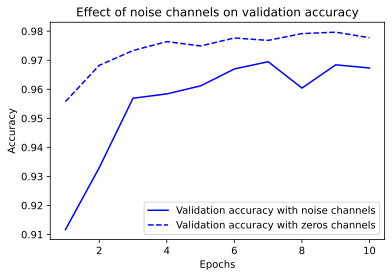

time: 710 ms (started: 2021-07-25 18:34:34 +08:00)


In [10]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]

epochs = range(1, 11)

plt.plot(epochs, val_acc_noise, "b-",
label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
label="Validation accuracy with zeros channels")

plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

尽管在两种情况下数据都包含相同的信息，但使用噪声通道训练的模型的验证准确度最终会降低约 1 个百分点——纯粹是由于虚假相关的影响。 您添加的噪声通道越多，精度将进一步降低。

嘈杂的特征不可避免地会导致过度拟合。 因此，如果您不确定您拥有的特征是提供信息还是分散注意力，通常在训练前进行特征选择。 例如，将 IMDB 数据限制在前 10,000 个最常见的词是一种粗略的特征选择形式。 进行特征选择的典型方法是为每个可用特征计算一些有用性分数——衡量特征对任务的信息量，例如特征和标签之间的互信息——并且只保留那些可用的特征 高于某个阈值。 这样做会过滤掉上面例子中的白噪声通道。

### 深度学习中泛化的本质

关于深度学习模型的一个显着事实是，只要它们具有足够的表示能力，就可以训练它们以适应任何事物。

不相信我？ 尝试改组 MNIST 标签并在其上训练模型。 即使输入和混洗后的标签之间没有任何关系，即使模型相对较小，训练损失也会下降得很好。 自然地，验证损失不会随着时间的推移而改善，因为在这种情况下没有泛化的可能性。

> 清单 5.4 使用随机打乱的标签拟合 MNIST 模型

In [11]:
(train_images, train_labels), _ = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]

np.random.shuffle(random_train_labels)

model = keras.Sequential([
 layers.Dense(512, activation="relu"),
 layers.Dense(10, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 4s 8ms/step - loss: 2.3162 - accuracy: 0.1040 - val_loss: 2.3076 - val_accuracy: 0.1077
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 2.3005 - accuracy: 0.1187 - val_loss: 2.3097 - val_accuracy: 0.1119
Epoch 3/100
375/375 [==============================] - 3s 8ms/step - loss: 2.2913 - accuracy: 0.1290 - val_loss: 2.3176 - val_accuracy: 0.1098
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 2.2778 - accuracy: 0.1415 - val_loss: 2.3211 - val_accuracy: 0.1014
Epoch 5/100
375/375 [==============================] - 3s 8ms/step - loss: 2.2596 - accuracy: 0.1546 - val_loss: 2.3370 - val_accuracy: 0.1028
Epoch 6/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2389 - accuracy: 0.1682 - val_loss: 2.3556 - val_accuracy: 0.0985
Epoch 7/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2132 - accuracy: 0.1837 - val_loss: 2.3667 - val_accuracy: 0.1024

time: 4min 57s (started: 2021-07-25 18:40:26 +08:00)


事实上，你甚至不需要用 MNIST 数据来做这件事——你可以只生成白噪声输入和随机标签。 您也可以在其上拟合模型，只要它有足够的参数。 它最终只会记住特定的输入，就像 Python 字典一样。

如果是这种情况，那么深度学习模型如何泛化呢？ 他们不应该只是学习训练输入和目标之间的临时映射，就像一个幻想吗？ 我们可以期望这个映射适用于新输入吗？

事实证明，深度学习中泛化的本质与深度学习模型本身关系不大，而与现实世界中的信息结构关系很大。 让我们来看看这里到底发生了什么。

**流形假说**

MNIST 分类器的输入（在预处理之前）是一个 28x28 的 0 到 255 之间的整数数组。因此可能输入值的总数是 256 的 784 次方——远大于宇宙中原子的数量。 然而，这些输入中很少有看起来像有效的 MNIST 样本：实际的手写数字仅占用所有可能的 28x28 uint8 数组的父子空间空间的一小部分。 更重要的是，这个子空间不仅仅是在父空间中随机散布的一组点：它是高度结构化的。

首先，有效手写数字的子空间是：如果你取一个样本并对其连续修改一点，它仍然可以识别为同一个手写数字。 此外，有效子空间中的所有样本都是通过穿过子空间的平滑路径。 这意味着如果你连接了两个随机的 MNIST 数字 A 和 B，就会存在一系列“中间”图像，将 A 变形为 B，这样两个连续的数字彼此非常接近（见图 5.7）。 也许在两个类之间的边界附近会有一些模糊的形状，但即使是这些形状看起来仍然很像数字。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstdzkq2yzj31bk0j6win.jpg)

在技术术语中，您会说手写数字在多种可能的 28x28 uint8 数组的空间内形成 a。 这是一个很大的词，但这个概念非常直观。 “流形”是某个父空间的低维子空间，它在局部类似于线性（欧几里得）空间。 例如，平面中的平滑曲线是二维空间中的一维流形，因为对于曲线的每个点，您都可以绘制一条切线（曲线可以在每个点上由一条线近似）。 3D 空间内的光滑表面是 2D 流形。 等等。

更一般地说，流形假设假定所有自然数据都位于编码它的高维空间内的低维流形上。 这是关于宇宙信息结构的一个非常有力的陈述。 据我们所知，它是准确的，这也是深度学习起作用的原因。 对于 MNIST 数字如此，对于人脸、树木形态、人声甚至自然语言也是如此。

流形假设意味着：
* 机器学习模型只需要在其潜在的输入空间（潜在流形）中拟合相对简单、低维、高度结构化的子空间。
* 在这些流形之一中，始终可以在两个输入之间进行插值，也就是说，通过所有点都落在流形上的连续路径将一个输入变形为另一个。

在样本之间进行插值的能力是理解深度学习泛化的关键。

**插值作为泛化源**

如果您使用可以插值的数据点，您可以开始理解以前从未见过的点，通过将它们与位于流形上的其他点相关联。 换句话说，您可以仅使用空间样本来理解空间的意义。 您的总体样本可以使用插值来填补空白。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gste6o6usij31cu0o0gob.jpg)

请注意，潜在流形上的插值与父空间中的线性插值不同，如图 5.8 所示。 例如，两个 MNIST 数字之间的像素平均值通常不是有效数字。

至关重要的是，虽然深度学习通过对数据流形的学习近似值进行插值来实现泛化，但假设插值就是泛化的全部内容是错误的。 这是冰山一角。 插值只能帮助您理解与您以前见过的非常接近的事物：它支持局部泛化。 但值得注意的是，人类一直在处理极端新奇事物，而且他们做得很好。 您无需事先接受有关您将不得不遇到的每种情况的无数示例的培训。 你的每一天都不同于你以前经历过的任何一天，也不同于自人类诞生以来任何人经历过的任何一天。 您可以在纽约一周、上海一周和班加罗尔一周之间切换，而无需为每个城市进行数千次的学习和排练。

人类能够进行极端概括，这是通过插值以外的认知机制实现的——抽象、世界的符号模型、推理、逻辑、常识、关于世界的先天先验。 我们通常所说的，与直觉和模式原因识别相反。 后者本质上在很大程度上是内插的，但前者不是。 两者对于智能都是必不可少的。 我们将在第 14 章详细讨论这一点。

**为什么深度学习有效**

还记得第 2 章中皱巴巴的纸球比喻吗？ 一张纸代表 3D 空间中的 2D 流形。 深度学习模型是一种用于解开纸团的工具，即用于解开潜在流形的工具。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsteaodbtsj31dk0ikjt7.jpg)

深度学习模型基本上是一条非常高维的曲线。 一条平滑且连续的曲线（对其结构有额外的约束，源自模型架构先验），因为它需要可微。 并且该曲线通过梯度下降（平滑且渐进）拟合到数据点。 通过构建，深度学习是采用一条大而复杂的曲线——一个流形——并逐步调整其参数，直到它适合一些训练数据点。

曲线包含足够多的参数，可以拟合任何东西——事实上，如果你让模型训练足够长的时间，它最终会有效地完全记住它的训练数据，根本不会泛化。 但是，您拟合的数据并不是由在底层空间中稀疏分布的孤立点组成的。 您的数据在输入空间内形成了一个高度结构化、低维的流形——这就是流形假设。 并且因为模型曲线与这些数据的拟合会随着时间的推移逐渐平滑地发生，随着梯度下降的进行，在训练过程中会有一个中间点，在该点模型大致接近数据的自然流形，如图 5.10 所示。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsted0w8lpj31es0octd2.jpg)

沿着模型在该点学习的曲线移动将接近沿着数据的实际潜在流形移动——因此，模型将能够通过训练输入之间的插值来理解从未见过的输入。

除了它们具有足够的表示能力这一微不足道的事实之外，深度学习模型还有一些特性使它们特别适合学习潜在流形：
1. 深度学习模型实现了从输入到输出的平滑、连续映射。 它必须是平滑和连续的，因为它必须是可微的（否则你不能做梯度下降）。 这种平滑性有助于逼近具有相同属性的潜在流形。
2. 深度学习模型的结构往往反映了训练数据中信息的“形状”（通过架构先验）。 对于图像处理模型（参见第 8 章和第 9 章）和序列处理模型（参见第 10 章）尤其如此。 更一般地说，深度神经网络以分层和模块化的方式构建他们学习的表示，这与自然数据的组织方式相呼应。

**训练数据至关重要**

虽然深度学习确实非常适合流形学习，但泛化能力更多是数据自然结构的结果，而不是模型任何属性的结果。 只有当您的数据形成可以插入点的流形时，您才能进行概括。 你的特征信息量越多，噪音越小，你的概括能力就越好，因为你的输入空间会更简单，结构也更好。 数据管理和特征工程对于泛化至关重要。

此外，由于深度学习是曲线拟合，为了使模型表现良好，需要对其输入空间的密集采样进行训练。 在这种情况下，“密集采样”意味着训练数据应该密集地覆盖整个输入数据流形（见图 5.11）。 在决策边界附近尤其如此。 通过足够密集的采样，可以通过在过去的训练输入之间进行插值来理解新输入，而无需使用常识、抽象推理或关于世界的外部知识——机器学习模型无法访问的所有事物。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstejo1o81j31ag0r641p.jpg)

因此，您应该始终牢记，改进深度学习模型的最佳方法是在更多数据或更好的数据上对其进行训练（当然，添加过于嘈杂或不准确的数据会损害泛化）。 输入数据流形的更密集覆盖将产生一个更好泛化的模型。 您永远不应该期望深度学习模型在其训练样本之间执行任何粗略的插值，因此，您应该尽一切可能使插值尽可能简单。 你会在深度学习模型中找到的唯一东西就是你放入其中的内容：在其架构中编码的先验，以及用于训练的数据。

当无法获取更多数据时，次优解决方案是调整模型允许存储的信息量，或者对模型曲线的平滑度添加约束。 如果网络只能记住少量模式或非常规则的模式，优化过程将迫使它专注于最突出的模式，这些模式有更好的泛化机会。 以这种方式对抗过拟合的处理称为正则化。 我们将在 5.4.4 节深入回顾正则化技术。

在开始调整模型以帮助它更好地泛化之前，您需要一种方法来评估模型当前的表现。 在下一节中，您将了解如何在模型开发过程中监控泛化：模型评估。

## 评估机器学习模型

你只能控制你能观察到的东西。 由于您的目标是开发可以成功泛化到新数据的模型，因此能够可靠地衡量模型的泛化能力至关重要。 在本节中，我们将正式介绍评估机器学习模型的不同方法。 您已经在上一章中看到了其中的大部分。

### 训练、验证和测试集

评估模型总是归结为将可用数据分成三组：训练、验证和测试。 您在训练数据上进行训练并在验证数据上评估您的模型。 一旦您的模型准备好迎接黄金时段，您就可以在测试数据上对其进行最后一次测试，这意味着尽可能与生产数据相似。 然后您可以在生产中部署模型。

你可能会问，为什么不用两个集合：一个训练集和一个测试集？ 您将在训练数据上进行训练并在测试数据上进行评估。 简单多了！

原因是开发模型总是涉及调整其配置：例如，选择层数或层的大小（称为模型的超参数，以区别于 ，后者是网络的权重）。 您可以通过使用模型在验证数据上的性能作为反馈信号来调整参数。 本质上，这种调整是一种形式：在某些参数空间中搜索良好的配置。 作为学习结果，根据模型在验证集上的性能调整模型的配置可能会很快导致对验证集的过度拟合，即使您的模型从未直接对其进行过训练。

这种现象的核心是信息泄漏的概念。 每次根据模型在验证集上的性能调整模型的超参数时，有关验证数据的一些信息就会泄漏到模型中。 如果您只对一个参数执行一次此操作，那么将泄漏很少的信息位，并且您的验证集将保持可靠以评估模型。 但是如果你重复这个过程很多次——运行一个实验，评估验证集，然后修改你的模型——那么你就会将越来越多的关于验证集的信息泄漏到模型中。

在一天结束时，您最终会得到一个在验证数据上人为执行良好的模型，因为这就是您对其进行优化的目的。 您关心全新的性能
数据，而不是验证数据，因此您需要使用完全不同的、前所未见的数据集来评估模型：测试数据集。 您的模型不应该访问任何信息
关于测试集，甚至是间接的。 如果根据测试集性能调整了有关模型的任何内容，那么您的泛化度量将有缺陷。

将数据拆分为训练、验证和测试集似乎很简单，但有一些高级方法可以在数据很少时派上用场。 让我们回顾一下三个经典的评估方法：简单的保持验证、K 折验证和带混洗的迭代 K 折验证。 我们还将讨论使用常识基线来检查您的训练是否在某个地方进行。

**简单的保持验证**

将数据的一部分作为测试集。 对剩余数据进行训练，并在测试集上进行评估。 正如您在前几节中看到的，为了防止信息泄漏，您不应该根据测试集调整模型，因此您还应该保留一个验证集。

示意性地，保持验证如图 5.12 所示。 下面的清单显示了一个简单的实现。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsteu6kivvj31g00sc40k.jpg)

> 清单 5.5 Hold-out 验证（注意为了简单起见省略了标签）

In [ ]:
num_validation_samples = 10000
np.random.shuffle(data)

validation_data = data[:num_validation_samples]
training_data = data[num_validation_samples:]

model = get_model()

model.fit(training_data, ...)

validation_score = model.evaluate(validation_data, ...) 

...
model = get_model()
model.fit(np.concatenate([training_data,
                          validation_data]), 
          ...) 
test_score = model.evaluate(test_data, ...)

这是最简单的评估协议，它有一个缺陷：如果可用数据很少，那么您的验证和测试集可能包含的样本太少，无法在统计上代表手头的数据。 这很容易识别：如果在拆分之前对数据进行不同的随机混洗轮最终会产生非常不同的模型性能度量，那么您就会遇到这个问题。 K 折验证和迭代 K 折验证是解决此问题的两种方法，如下所述。

**K 折验证**

使用这种方法，您可以将数据拆分为大小相等的分区。 对于每个分区 i，在剩余分区上训练一个 K-1 模型，并在分区 上对其进行评估。 您的最终分数是所获得的 K 分数的平均值。 当您的模型性能根据您的训练测试拆分显示出显着差异时，此方法很有用。 与保留验证一样，此方法并不能免除您使用不同的验证集进行模型校准。 

K 折交叉验证的示意图如图 5.13 所示。 清单 5.6 展示了一个简单的实现。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsteyc3stgj31cc0lmgnq.jpg)

> 清单 5.6 K 折交叉验证（注意为简单起见省略了标签）

In [ ]:
k = 3
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []

for fold in range(k):
    validation_data = data[num_validation_samples * fold:num_validation_samples * (fold + 1)] 
    training_data = np.concatenate(data[:num_validation_samples * fold],
                                   data[num_validation_samples * (fold + 1):])
    model = get_model()
    model.fit(training_data, ...)
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)
        
validation_score = np.average(validation_scores)
model = get_model()
model.fit(data, ...)
test_score = model.evaluate(test_data, ...)

**带洗牌的迭代 K 折验证**

这适用于可用数据相对较少且需要尽可能精确地评估模型的情况。 我发现它在 Kaggle 比赛中非常有帮助。 它包括多次应用 K 折验证，每次在将数据拆分 K 种方式之前对数据进行混洗。 最终分数是每次运行 K 折验证时获得的分数的平均值。 请注意，您最终会训练和评估 P * K 模型（其中 P 是您使用的迭代次数），这可能非常昂贵。

### 击败常识基线

除了您可用的不同评估协议之外，您还应该了解的最后一件事是使用常识基线。

训练深度学习模型有点像在平行世界按下按钮发射火箭。 你听不到也看不到。 你无法观察流形学习过程——它发生在一个有数千个维度的空间中，即使你将它投影到 3D，你也无法解释它。 您获得的唯一反馈是您的验证指标——例如隐形火箭上的高度计。

特别重要的一点是能够判断您是否完全脱离了地面。 你开始的高度是多少？ 你的模型似乎有 15% 的准确率，这有什么好处吗？ 在开始使用数据集之前，您应该始终选择一个您将尝试击败的微不足道的基线。 如果你超过了这个门槛，你就会知道你做对了：你的模型实际上是在使用输入数据中的信息来进行泛化预测——你可以继续前进。 该基线可以是随机分类器的性能，也可以是您可以想象的最简单的非机器学习技术的性能。

例如，在 MNIST 数字分类示例中，一个简单的基线是验证准确度大于 0.1（随机分类器）； 在 IMDB 示例中，验证准确度将大于 0.5。 在路透社的例子中，由于类别不平衡，它将在 0.18-0.19 左右。 如果您有一个二元分类问题，其中 90% 的样本属于 A 类，10% 属于 B 类，那么始终预测 A 的分类器的验证准确率已经达到 0.9，您需要做得比这更好。

当你开始解决一个以前没有人解决过的问题时，拥有一个可以参考的常识基线是必不可少的。 如果您无法击败一个微不足道的解决方案，那么您的模型就毫无价值——也许您使用了错误的模型，或者您正在解决的问题甚至无法首先通过机器学习来解决。 是时候回到绘图板了。

### 关于模型评估的注意事项

在选择评估协议时，请注意以下几点：
* **数据代表性**——你希望你的训练集和测试集都能代表手头的数据。 例如，如果您尝试对数字图像进行分类，并且您从一个样本数组开始，其中样本按类别排序，则将数组的前 80% 作为训练集，其余 20% 因为您的测试集将导致您的训练集仅包含 0-7 类，而您的测试集仅包含 8-9 类。 这似乎是一个荒谬的错误，但它却出奇地普遍。 出于这个原因，您通常应该在将数据拆分为训练集和测试集之前随机打乱数据。
* **时间之箭**——如果你想根据过去预测未来（例如，明天的天气、股票走势等），你不应该在拆分数据之前随机打乱数据，因为这样做会创建一个时间序列 泄漏：您的模型将有效地接受未来数据的训练。 在这种情况下，您应该始终确保测试集中的所有数据都对应于训练集中的数据。
* **数据中的冗余**——如果数据中的某些数据点出现两次（在现实世界中很常见），那么将数据打乱并将其拆分为训练集和验证集将导致训练集和验证集之间出现冗余。 实际上，您将测试部分训练数据，这是您能做的最糟糕的事情！ 确保您的训练集和验证集不相交。

有一种可靠的方法来评估模型的性能，是您如何能够监控机器学习核心的张力——优化和泛化、欠拟合和过拟合。

## 改进模型拟合

为了达到完美的拟合，你必须首先过拟合。 既然你事先不知道边界在哪里，你必须越过它才能找到它。 因此，当您开始解决问题时，您的初始目标是实现一个模型，该模型具有一定的泛化能力，并且能够过拟合。 一旦你有了这样的模型，你将专注于通过对抗过度拟合来完善泛化。

在这个阶段你会遇到三个常见的问题：
* 训练没有开始：你的训练损失不会随着时间的推移而减少。
* 训练开始得很好，但你的模型没有有意义的概括：你无法击败你设置的常识基线。
* 训练和验证损失都随着时间的推移而下降，你可以超过基线，但你似乎无法过拟合——这表明你仍然欠拟合。

让我们看看如何解决这些问题以实现机器学习项目的第一个重要里程碑：获得一个具有一定泛化能力（它可以击败微不足道的基线）并且能够过度拟合的模型。

### 调整关键梯度下降参数

有时，培训没有开始，或者过早停止。 你的损失被卡住了。 这始终是您可以克服的：请记住，您可以将模型拟合到随机数据。 即使你的问题没有任何意义，你也应该能够训练一些东西——只要仍然记住训练数据。

发生这种情况时，梯度下降过程的配置始终存在问题：您选择的优化器、模型权重的初始值分布、学习率或批量大小。 所有这些参数都是相互依赖的，因此，在保持其余参数不变的同时调整学习率和批量大小通常就足够了。

让我们看一个具体的例子：让我们训练第 2 章中的 MNIST 模型，使用不恰当的大学习率，值为 1。

> 清单 5.7 以错误的高学习率训练 MNIST 模型

In [28]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, 
          train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 8ms/step - loss: 27.7234 - accuracy: 0.1900 - val_loss: 2.1154 - val_accuracy: 0.2252
Epoch 2/10
375/375 [==============================] - 3s 7ms/step - loss: 2.3795 - accuracy: 0.2013 - val_loss: 2.0841 - val_accuracy: 0.2294
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 2.2546 - accuracy: 0.2023 - val_loss: 1.9762 - val_accuracy: 0.2538
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 2.1286 - accuracy: 0.2598 - val_loss: 1.7637 - val_accuracy: 0.3400
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 1.9951 - accuracy: 0.2859 - val_loss: 1.7126 - val_accuracy: 0.3251
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 1.9974 - accuracy: 0.2924 - val_loss: 2.6586 - val_accuracy: 0.2213
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 1.9916 - accuracy: 0.2870 - val_loss: 2.0091 - val_accuracy: 0.3162
Epoch

time: 29.7 s (started: 2021-07-25 20:53:24 +08:00)


该模型很快达到了 30%-40% 范围内的训练和验证准确率，但无法超过这个范围。 让我们尝试将学习率降低到更合理的值 1e-2：

> 清单 5.8 具有更合适学习率的相同模型

In [27]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, 
          train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3486 - accuracy: 0.9128 - val_loss: 0.1742 - val_accuracy: 0.9531
Epoch 2/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1443 - accuracy: 0.9637 - val_loss: 0.1606 - val_accuracy: 0.9638
Epoch 3/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1166 - accuracy: 0.9727 - val_loss: 0.2224 - val_accuracy: 0.9644
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1056 - accuracy: 0.9783 - val_loss: 0.1895 - val_accuracy: 0.9709
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0870 - accuracy: 0.9811 - val_loss: 0.2133 - val_accuracy: 0.9695
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0790 - accuracy: 0.9847 - val_loss: 0.2298 - val_accuracy: 0.9722
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0690 - accuracy: 0.9870 - val_loss: 0.2510 - val_accuracy: 0.9722
Epoch 

time: 30 s (started: 2021-07-25 20:52:25 +08:00)


该模型现在可以训练了。

如果您发现自己处于类似情况，请尝试：
* 降低或提高学习率。 太高的学习率可能会导致更新大大超过适当的拟合，就像上面的例子一样，而太低的学习率可能会使训练变得如此缓慢，以至于它似乎停滞不前。
* 增加批量大小。 具有更多样本的批次将导致梯度信息更多且噪声更少（方差更低）。

最终，您将找到一个可以开始训练的配置。

### 利用更好的先验架构

您有一个适合的模型，但由于某种原因，您的验证指标根本没有改善。 它们仍然不比随机分类器所能实现的更好：您的模型训练，但是不能泛化。 这是怎么回事？

这可能是你能发现的最糟糕的机器学习情况。这表明你的方法存在根本性的问题，而且可能不容易判断是什么。 这里有一些提示。

首先，可能是您使用的输入数据根本没有包含足够的信息来预测您的目标：公式化的问题无法解决。 这就是之前我们尝试拟合一个标签被打乱的 MNIST 模型时发生的情况：模型可以训练得很好，但验证准确率会停留在 10%，因为显然不可能用这样的数据集进行泛化。

也可能是您使用的模型类型不适合手头的问题。 例如，在第 10 章中，您将看到一个时间序列预测问题的示例，其中密集连接的架构无法击败微不足道的基线，而更合适的循环架构确实能够很好地泛化。 使用对问题做出正确假设的模型对于实现泛化至关重要：您应该利用正确的先验架构。

在接下来的章节中，您将了解用于各种数据模式（图像、文本、时间序列等）的最佳架构。 一般来说，您应该始终确保阅读有关您正在攻击的任务类型的架构最佳实践，您可能不是第一个尝试它的人。

### 增加模型容量

如果你设法得到一个合适的模型，验证指标正在下降，而且这似乎至少达到了一定程度的泛化能力，恭喜：你就快到了。 接下来，您需要让您的模型开始过度拟合。

考虑以下在 MNIST 像素上训练的小模型——一个简单的逻辑回归。

> 清单 5.9 MNIST 上的简单逻辑回归

In [25]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_small_model = model.fit(
    train_images, 
    train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 0.6716 - accuracy: 0.8339 - val_loss: 0.3588 - val_accuracy: 0.9040
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.3508 - accuracy: 0.9038 - val_loss: 0.3078 - val_accuracy: 0.9149
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.3156 - accuracy: 0.9127 - val_loss: 0.2893 - val_accuracy: 0.9186
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2991 - accuracy: 0.9169 - val_loss: 0.2835 - val_accuracy: 0.9194
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2897 - accuracy: 0.9190 - val_loss: 0.2772 - val_accuracy: 0.9212
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2828 - accuracy: 0.9212 - val_loss: 0.2730 - val_accuracy: 0.9245
Epoch 7/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2781 - accuracy: 0.9229 - val_loss: 0.2698 - val_accuracy: 0.9268
Epoch 

您会得到如下所示的损失曲线：

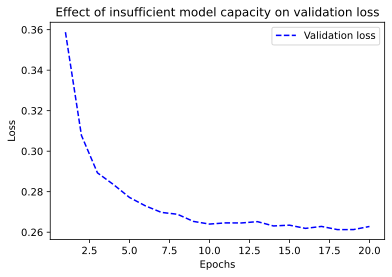

time: 277 ms (started: 2021-07-25 20:52:17 +08:00)


In [26]:
import matplotlib.pyplot as plt

val_loss = history_small_model.history["val_loss"]

epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",label="Validation loss")

plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

验证指标似乎停滞不前，或者改善非常缓慢，而不是达到峰值和逆转过程。 验证损失达到 0.26 并保持在那里。 你可以拟合，但你不能明显地过度拟合，即使在对训练数据进行多次迭代之后也是如此。 在您的职业生涯中，您可能会经常遇到类似的曲线。

请记住，过拟合应该总是可能的。 就像“训练损失不会下降”的问题一样，这是一个总是可以解决的问题。 如果您似乎无法过度拟合，则可能是模型的表示能力存在问题：您将需要一个更大的模型。 一个多，也就是说，能够存储更多的信息。 您可以通过添加更多层、使用更大的层（具有更多参数的层）或使用更适合手头问题的层（更好的架构先验）来提高表示能力。

让我们尝试训练一个更大的模型，一个有两个中间层，每个层有 96 个单元：

In [37]:
model = keras.Sequential([
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_large_model = model.fit(
    train_images, 
    train_labels,
    epochs=50,
    batch_size=128,
    validation_split=0.2)

Epoch 1/50
375/375 [==============================] - 4s 8ms/step - loss: 0.8065 - accuracy: 0.7436 - val_loss: 0.3944 - val_accuracy: 0.8880
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 0.3578 - accuracy: 0.8922 - val_loss: 0.2840 - val_accuracy: 0.9124
Epoch 3/50
375/375 [==============================] - 3s 8ms/step - loss: 0.2745 - accuracy: 0.9172 - val_loss: 0.2243 - val_accuracy: 0.9338
Epoch 4/50
375/375 [==============================] - 3s 7ms/step - loss: 0.2149 - accuracy: 0.9348 - val_loss: 0.1762 - val_accuracy: 0.9480
Epoch 5/50
375/375 [==============================] - 3s 7ms/step - loss: 0.1732 - accuracy: 0.9475 - val_loss: 0.1582 - val_accuracy: 0.9516
Epoch 6/50
375/375 [==============================] - 3s 7ms/step - loss: 0.1422 - accuracy: 0.9562 - val_loss: 0.1456 - val_accuracy: 0.9557
Epoch 7/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1181 - accuracy: 0.9641 - val_loss: 0.1262 - val_accuracy: 0.9623
Epoch 

训练曲线现在看起来和它们应该的完全一样：模型拟合得很快，并且在 8 个 epoch 后开始过度拟合。

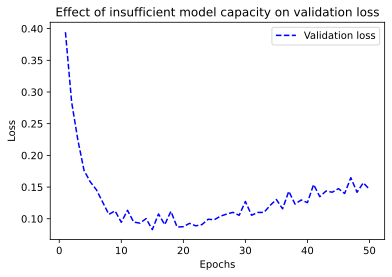

time: 329 ms (started: 2021-07-25 21:08:58 +08:00)


In [39]:
import matplotlib.pyplot as plt

val_loss = history_large_model.history["val_loss"]

epochs = range(1, 51)
plt.plot(epochs, val_loss, "b--",label="Validation loss")

plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

训练曲线现在看起来和它们应该的完全一样：模型拟合得很快，并且在 20 个 epoch 后开始过度拟合。

## 提高泛化能力

一旦您的模型显示出一定的泛化能力并能够过拟合，就该将注意力转向最大化泛化。

### 数据集管理

您已经了解到深度学习中的泛化源于数据的潜在结构。 如果您的数据可以在样本之间平滑插入，那么您将能够训练一个泛化的深度学习模型。 如果您的问题过于嘈杂或从根本上是离散的，例如列表排序，深度学习将无济于事。 深度学习是曲线拟合，而不是魔法。

因此，确保您使用的是合适的数据集至关重要。 在数据收集上花费更多的精力和金钱几乎总是比在开发更好的模型上花费相同的钱获得更高的投资回报。
* 确保你有足够的数据。 请记住，您需要对输入交叉输出空间进行密集采样。 更多的数据将产生更好的模型。 有时，一开始看起来不可能的问题可以通过更大的数据集解决。
* 最大限度地减少标签错误——可视化您的输入以检查异常，并校对您的标签。
* 清理您的数据并处理缺失值（我们将在下一章中介绍）。
* 如果您有很多功能，但不确定哪些功能真正有用，请进行功能选择。

可以提高数据泛化潜力的一个特别重要的方法是特征工程。 对于大多数机器学习问题，特征工程是成功的关键因素。 让我们来看看。

### 特征工程

特征工程是利用您自己对数据和手头机器学习算法（在本例中为神经网络）的知识，通过对数据应用硬编码（非学习）转换来使算法更好地工作的过程 它进入模型。 在许多情况下，期望机器学习模型能够从完全任意的数据中学习是不合理的。 数据需要以某种方式呈现给模型
使模型的工作更轻松。

让我们看一个直观的例子。 假设您正在尝试开发一个模型，该模型可以将时钟图像作为输入并输出一天中的时间（见图 5.16）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstjcprvryj30ro0pmq4v.jpg)

如果您选择使用图像的原始像素作为输入数据，那么您将面临一个棘手的机器学习问题。 你需要一个卷积神经网络来解决它，你必须花费相当多的计算资源来训练网络。

但是如果你已经从高层次理解了这个问题（你理解人类如何在钟面上读时间），那么你可以为机器学习想出更好的输入特征
算法：例如，很容易写一个五行 Python 脚本来跟踪时钟指针的黑色像素并输出每根指针的尖端坐标。 然后一个简单的 (x, y) 机器学习算法可以学习将这些坐标与一天中的适当时间相关联。

您可以更进一步：进行坐标更改，并将坐标表示为相对于图像中心的极坐标 (x, y) 坐标。 您的输入将成为每个时钟指针的 theta 角。 此时，您的功能使问题变得如此简单，以至于不需要机器学习； 一个简单的舍入操作和字典查找就足以恢复一天中的大致时间。

这就是特征工程的本质：通过以更简单的方式表达问题，从而使问题更容易。 使潜在流形更平滑、更简单、更有条理。 它通常需要深入了解问题。

在深度学习之前，特征工程曾经是机器学习工作流程中最重要的部分，因为经典的浅层算法没有足够丰富的假设空间来自行学习有用的特征。 您将数据呈现给算法的方式对其成功至关重要。 例如，在卷积神经网络在 MNIST 数字分类问题上取得成功之前，解决方案通常基于
硬编码特征，例如数字图像中的循环次数、图像中每个数字的高度、像素值的直方图等。

幸运的是，现代深度学习消除了对大多数特征工程的需求，因为神经网络能够从原始数据中自动提取有用的特征。 这是否意味着只要使用深度神经网络就不必担心特征工程？ 不，有两个原因：
* 好的功能仍然可以让您在使用更少资源的同时更优雅地解决问题。 例如，使用卷积神经网络解决读取钟面的问题是荒谬的。
* 好的特性让你用更少的数据解决问题。 深度学习模型自行学习特征的能力依赖于大量可用的训练数据； 如果您只有几个样本，那么其特征中的信息值就变得至关重要。

### 使用提前停止

在深度学习中，我们总是使用过度参数化的模型：它们的自由度比拟合数据潜在流形所需的最小自由度大得多。 这种过度参数化不是问题，因为您永远无法完全拟合深度学习模型。 这样的契合根本无法推广。 在达到最小可能的训练损失之前，您总是会中断训练。

在训练期间找到达到最可泛化拟合的确切点（欠拟合曲线和过拟合曲线之间的确切边界）是提高泛化能力的最有效方法之一。

在前一章的例子中，我们首先训练我们的模型比需要的时间长，以确定产生最佳验证指标的时期数，然后我们将重新训练一个新模型，精确到该时期数。 这是很标准的。 但是，它需要您做多余的工作，这有时会很昂贵。 当然，您可以在每个 epoch 结束时保存您的模型，然后一旦找到最佳 epoch，就可以重用您拥有的最接近的保存模型。 在 Keras 中，通常使用 EarlyStopping 回调来执行此操作，一旦验证指标停止改进，它就会中断训练，同时记住最知名的模型状态。 你将在第 7 章学习使用回调。

### 正则化你的模型

正则化技术是一组最佳实践，它们会积极阻碍模型完美拟合训练数据的能力，目的是使模型在验证过程中表现更好。 这被称为“正则化”模型，因为它倾向于使模型更简单、更“规则”、曲线更平滑、更“通用”——因此对训练集不那么具体，并且能够通过更接近潜在的 数据的多样性。

请记住，“规范化”模型是一个应始终以准确的评估程序为指导的过程。 如果您可以衡量它，您将只能实现泛化。

让我们回顾一些最常见的正则化技术，并在实践中应用它们来改进第 4 章中的电影分类模型。

**缩小网络规模**

您已经了解到太小的模型不会过拟合。减轻过拟合的最简单方法是减小模型的大小（模型中可学习参数的数量，由层数和每层单元数决定）。如果模型的记忆资源有限，它就不能简单地记忆它的训练数据；因此，为了最小化其损失，它将不得不求助于学习压缩表示
关于目标的预测能力——正是我们感兴趣的表示类型。同时，请记住，您应该使用具有足够参数且不会欠拟合的模型：您的模型不应该因记忆而饿死资源。在容量过多和容量不足之间存在折衷。

不幸的是，没有神奇的公式来确定正确的层数或每层的正确大小。您必须评估一系列不同的架构（当然是在您的验证集上，而不是在您的测试集上），以便为您的数据找到正确的模型大小。找到合适模型大小的一般工作流程是从相对较少的层和参数开始，然后增加层的大小或添加新层，直到您看到验证损失的收益递减。

让我们在电影评论分类模型上试试这个。 这是我们的原始模型：

> 清单 5.10 原始模型

In [43]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_original = model.fit(train_data, 
                             train_labels,
                             epochs=20, 
                             batch_size=512, 
                             validation_split=0.4)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wit

Epoch 1/20
30/30 [==============================] - 3s 56ms/step - loss: 0.5699 - accuracy: 0.7497 - val_loss: 0.4523 - val_accuracy: 0.8459
Epoch 2/20
30/30 [==============================] - 1s 29ms/step - loss: 0.3615 - accuracy: 0.8912 - val_loss: 0.3352 - val_accuracy: 0.8808
Epoch 3/20
30/30 [==============================] - 1s 29ms/step - loss: 0.2595 - accuracy: 0.9205 - val_loss: 0.2924 - val_accuracy: 0.8901
Epoch 4/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2008 - accuracy: 0.9380 - val_loss: 0.2791 - val_accuracy: 0.8913
Epoch 5/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1641 - accuracy: 0.9482 - val_loss: 0.2724 - val_accuracy: 0.8929
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1366 - accuracy: 0.9586 - val_loss: 0.2811 - val_accuracy: 0.8878
Epoch 7/20
30/30 [==============================] - 1s 39ms/step - loss: 0.1149 - accuracy: 0.9651 - val_loss: 0.2970 - val_accuracy: 0.8865
Epoch 8/20
30

现在让我们尝试用这个较小的模型替换它。

> Listing 5.11 容量较低的模型版本

In [44]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_smaller_model = model.fit(train_data, 
                                  train_labels,
                                  epochs=20, 
                                  batch_size=512, 
                                  validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 3s 63ms/step - loss: 0.5981 - accuracy: 0.7682 - val_loss: 0.5294 - val_accuracy: 0.8470
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.4554 - accuracy: 0.8757 - val_loss: 0.4327 - val_accuracy: 0.8530
Epoch 3/20
30/30 [==============================] - 1s 30ms/step - loss: 0.3655 - accuracy: 0.9018 - val_loss: 0.3648 - val_accuracy: 0.8812
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 0.2975 - accuracy: 0.9181 - val_loss: 0.3279 - val_accuracy: 0.8845
Epoch 5/20
30/30 [==============================] - 1s 29ms/step - loss: 0.2486 - accuracy: 0.9286 - val_loss: 0.2983 - val_accuracy: 0.8894
Epoch 6/20
30/30 [==============================] - 1s 27ms/step - loss: 0.2122 - accuracy: 0.9379 - val_loss: 0.2850 - val_accuracy: 0.8922
Epoch 7/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1839 - accuracy: 0.9464 - val_loss: 0.2910 - val_accuracy: 0.8827
Epoch 8/20
30

图 5.17 显示了原始模型和较小模型的验证损失的比较。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstjtpuvrwj31a20twwhx.jpg)

如您所见，较小的模型开始过拟合的时间晚于参考模型（在 6 个 epoch 之后而不是 4 个 epoch 之后），并且一旦开始过拟合，其性能下降得更慢。

现在，让我们将一个容量更大的模型添加到我们的基准测试中——远远超出问题所保证的范围。 虽然使用对于他们试图学习的东西明显过度参数化的模型是标准的，但肯定会有太多的记忆容量这样的事情。 如果您的模型立即开始过度拟合，并且其验证损失曲线看起来不稳定、高方差（尽管不稳定的验证指标也可能是使用不可靠验证过程的症状，例如验证拆分），您就会知道您的模型太大了 太小）。

> 清单 5.12 更高容量的模型版本

In [46]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_larger_model = model.fit(train_data, 
                                 train_labels,
                                 epochs=20, 
                                 batch_size=512, 
                                 validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 4s 74ms/step - loss: 0.5607 - accuracy: 0.7417 - val_loss: 0.3201 - val_accuracy: 0.8687
Epoch 2/20
30/30 [==============================] - 1s 35ms/step - loss: 0.2606 - accuracy: 0.8982 - val_loss: 0.2700 - val_accuracy: 0.8960
Epoch 3/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1487 - accuracy: 0.9447 - val_loss: 0.2924 - val_accuracy: 0.8907
Epoch 4/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1129 - accuracy: 0.9595 - val_loss: 0.3202 - val_accuracy: 0.8873
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0691 - accuracy: 0.9825 - val_loss: 0.3796 - val_accuracy: 0.8633
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0091 - accuracy: 0.9993 - val_loss: 0.4874 - val_accuracy: 0.8882
Epoch 7/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.5994 - val_accuracy: 0.8846
Epoch 8/20
30

图 5.18 显示了较大模型与参考模型相比的情况。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstjxxt1b9j313m0r8419.jpg)

较大的模型几乎立即开始过拟合，仅在一个 epoch 之后，并且过拟合得更严重。 它的验证损失也更嘈杂。 它很快使训练损失接近于零。 模型容量越大，对训练数据建模的速度就越快（导致训练损失较低），但越容易过拟合（导致训练和验证损失之间存在较大差异）。

**增加权重正则化**

您可能熟悉奥卡姆剃刀原理：对某事给出两种解释，最可能正确的解释是最简单的解释——假设较少的解释。 这个想法也适用于神经网络学习的模型：给定一些训练数据和网络架构，多组权重值（multiple）可以模型解释数据。 与复杂模型相比，简单模型不太可能过度拟合。

在这种情况下，一个简单的模型是参数值分布具有较少熵的模型（或具有较少参数的模型，如您在上一节中所见）。 因此，减轻过度拟合的一种常见方法是通过强制其权重仅取较小值来限制模型的复杂性，这使得权重值的分布更加规则。 这称为权重正则化，它是通过向模型的损失函数添加与具有大权重相关的成本来完成的。 这个成本有两种形式：
* L1 正则化——增加的成本与权重系数范数（权重的 L1）的绝对值成正比。
* L2 正则化——增加的成本与权重系数 L2 范数（权重的值）的平方成正比。 L2 正则化在神经网络的上下文中也称为权重衰减。 不要让不同的名称混淆你：权重衰减在数学上与 L2 正则化相同。

在 Keras 中，通过将权重正则化器实例作为关键字参数传递给层来添加权重正则化。 让我们将 L2 权重正则化添加到电影评论分类模型中。

In [47]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_l2_reg = model.fit(train_data, 
                           train_labels,
                           epochs=20, 
                           batch_size=512, 
                           validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 3s 60ms/step - loss: 0.5861 - accuracy: 0.7853 - val_loss: 0.4547 - val_accuracy: 0.8749
Epoch 2/20
30/30 [==============================] - 1s 29ms/step - loss: 0.3961 - accuracy: 0.8972 - val_loss: 0.4010 - val_accuracy: 0.8727
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.3346 - accuracy: 0.9153 - val_loss: 0.3652 - val_accuracy: 0.8910
Epoch 4/20
30/30 [==============================] - 1s 33ms/step - loss: 0.3047 - accuracy: 0.9224 - val_loss: 0.3636 - val_accuracy: 0.8874
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.2858 - accuracy: 0.9293 - val_loss: 0.3634 - val_accuracy: 0.8849
Epoch 6/20
30/30 [==============================] - 1s 29ms/step - loss: 0.2707 - accuracy: 0.9353 - val_loss: 0.3666 - val_accuracy: 0.8844
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.2604 - accuracy: 0.9377 - val_loss: 0.3750 - val_accuracy: 0.8801
Epoch 8/20
30

l2(0.002) 表示该层权重矩阵中的每个系数都会将 0.002 *weight_coefficient_value ** 2 添加到模型的总损失中。 请注意，由于此惩罚仅在训练时添加，因此此模型在训练时的损失将远高于测试时
时间。

图 5.19 显示了 L2 正则化惩罚的影响。 如您所见，具有 L2 正则化的模型比参考模型更能抵抗过度拟合，即使两个模型具有相同数量的参数。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstk6zidd0j31aa0ts41n.jpg)

作为 L2 正则化的替代方法，您可以使用以下 Keras 权重正则化器之一。

In [51]:
from tensorflow.keras import regularizers

# L1正则化
regularizers.l1(0.001)

# L1+L2正则化
regularizers.l1_l2(l1=0.001, l2=0.001)

time: 3.67 ms (started: 2021-07-25 22:23:51 +08:00)


请注意，权重正则化更常用于较小的深度学习模型。 大型深度学习模型往往过于参数化，以至于对权重值施加约束对模型容量和泛化没有太大影响。 在这些情况下，首选不同的正则化技术：dropout。

**增加Dropout**

Dropout 是最有效和最常用的神经网络正则化技术之一，由 Geoff Hinton 和他在多伦多大学的学生开发。 应用于层的 Dropout 包括在训练期间随机丢弃（设置为零）该层的许多输出特征。 假设一个给定的层通常会在训练期间为给定的输入样本返回一个向量 [0.2, 0.5, 1.3, 0.8, 1.1]。 应用 dropout 后，该向量将随机分布一些零条目：例如，[0, 0.5,
1.3, 0, 1.1]。 丢失率是被归零的特征的分数； 它通常设置在 0.2 和 0.5 之间。 在测试时，没有单元被丢弃； 相反，该层的输出值按等于 dropout 率的因子缩小，以平衡比训练时更多的单元处于活动状态这一事实。

考虑一个包含层输出的 NumPy 矩阵，layer_output，形状为 (batch_size, features)。 在训练时，我们随机将矩阵中的一小部分值归零：

In [ ]:
# 训练时
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)

在测试时，我们按丢弃率缩小输出。 在这里，我们按 0.5 进行缩放（因为我们之前减少了一半的单位）：

In [ ]:
# 测试时
layer_output *= 0.5

请注意，此过程可以通过在训练时执行这两个操作并在测试时保持输出不变来实现，这通常是实践中的实现方式（见图 5.20）：

In [ ]:
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) 
layer_output /= 0.5

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstkekuqcaj31be0jq41h.jpg)

这种技术可能看起来很奇怪和随意。 为什么这有助于减少过拟合？ Hinton 说，他的灵感来自银行使用的欺诈预防机制等。 用他自己的话说，“我去了我的银行。柜员一直在变化，我问其中一个为什么。他说他不知道，但他们经常搬家。我想这一定是因为这需要双方合作。 员工成功地欺骗了银行。这让我意识到，在每个样本中随机删除不同的神经元子集可以防止阴谋，从而减少过度拟合。” 核心思想是在层的输出值中引入噪声可以打破不重要的偶然模式（Hinton 称之为阴谋），如果不存在噪声，模型将开始记忆。

在 Keras 中，您可以通过层在模型中引入 dropout，该层应用于它之前的层的 Dropout 输出。 让我们在 IMDB 模型中添加两层，看看 Dropout 在减少过拟合方面做得如何。

In [52]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_dropout = model.fit(train_data, 
                            train_labels,
                            epochs=20, 
                            batch_size=512, 
                            validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 3s 59ms/step - loss: 0.6379 - accuracy: 0.6217 - val_loss: 0.5094 - val_accuracy: 0.8311
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 0.5200 - accuracy: 0.7561 - val_loss: 0.4224 - val_accuracy: 0.8668
Epoch 3/20
30/30 [==============================] - 1s 31ms/step - loss: 0.4433 - accuracy: 0.8172 - val_loss: 0.3512 - val_accuracy: 0.8815
Epoch 4/20
30/30 [==============================] - 1s 31ms/step - loss: 0.3751 - accuracy: 0.8582 - val_loss: 0.3037 - val_accuracy: 0.8874
Epoch 5/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3216 - accuracy: 0.8835 - val_loss: 0.2846 - val_accuracy: 0.8900
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2835 - accuracy: 0.9035 - val_loss: 0.2813 - val_accuracy: 0.8879
Epoch 7/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2557 - accuracy: 0.9167 - val_loss: 0.2793 - val_accuracy: 0.8927
Epoch 8/20
30

图 5.21 显示了结果图。 这是对参考模型的明显改进——它似乎也比 L2 正则化工作得更好，因为达到的最低验证损失有所改善。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gstkiqvg3zj31680te77a.jpg)

回顾一下，这些是在神经网络中最大化泛化和防止过度拟合的最常见方法：
* 获取更多的训练数据，或者更好的训练数据。
* 开发更好的特征。
* 减少模型的容量。
* 添加权重正则化（对于较小的模型）。
* 添加dropout。

## 章节总结
* 机器学习模型的目的是：准确地概括从未见过的输入。 这比看起来更难。
* 深度神经网络通过学习一个可以在训练样本之间成功的参数模型来实现泛化——这样的模型可以说是对训练数据的“潜在流形”进行了插值学习。 这就是为什么深度学习模型只能理解与他们在训练期间看到的非常接近的输入。
* 机器学习中的根本问题是优化和泛化之间的紧张关系：要获得泛化，你必须首先对训练数据实现良好的拟合，但提高模型对训练数据的拟合一段时间后不可避免地会开始损害泛化。 每一个深度学习最佳实践都涉及管理这种紧张局势。
* 深度学习模型的泛化能力来自这样一个事实，即它们设法学习近似其数据的潜在流形，因此可以通过插值来理解新输入。
* 在开发模型时，能够准确评估模型的泛化能力至关重要。您可以随意使用一系列评估方法，从简单的保留验证到 K 折交叉验证和带改组的迭代 K 折交叉验证。请记住始终为最终模型评估保留一个完全独立的测试集，因为可能已经发生了从验证数据到模型的信息泄漏。
* 当您开始研究模型时，您的目标首先是实现一个具有一定泛化能力且可能会过拟合的模型。这样做的最佳实践包括调整学习率和批量大小、利用更好的架构先验、增加模型容量或简单地训练更长时间。
* 当您的模型开始过度拟合时，您的目标将转向通过模型正则化来提高泛化能力。您可以减少模型的容量，添加 dropout 或权重正则化，并使用提前停止。自然，更大或更好的数据集始终是帮助模型泛化的首选方法。